# Visual Analytics Group Project

### Simple Table of Contents

0. Imports 
1. Preprocessing the movie data set
2. Having a more statistical view onto the dataset
3. Deeper look into the data
4. Interactive working with clusters
5. Conclusion

## 0. Imports

In [1]:
import ast
import re # regular expression
import pycountry_convert as pc # helps to sort countries to continents

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
import seaborn as sns
import altair as alt
from ipywidgets import interact, interact_manual # for interaction

from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans # for clustering

#  1. Preprocessing the movie data set

- null values
- duplicates
- format check for example: numbers are not saved as strings

In [2]:
def df_contains_nan_raws(df):
    if df.shape == df.dropna(how='all').shape:
        print("in this dataset there are no rows where every entry is 0")
        return False
    else:
        df = df.dropna(how='all')
        print("the rows where every entry is 0 have been removed")
        return df

In [3]:
def remove_nan_rows(pandasdata_frame): # returns pandas dataframe without rows that had nan values
    print("..info from the remove_nan_rows() call..")
    print("the shape of the input was: ", pandasdata_frame.shape)
    pandasdata_frame = pandasdata_frame.dropna(how="any")
    print("the shape of the output is: ",pandasdata_frame.shape)
    return pandasdata_frame.reset_index(drop= True) # to reset the indexes of the data after nan removing

#remove_nan_rows(df)    # example usage

In [4]:
def rem_nan_specified(pandas_df, *colum_names): # removes nan value containing rows of all specified columumns (minimum 1)
    print("the shape of the input was: ", pandas_df.shape)    
    pandas_df = pandas_df.dropna(subset=colum_names)
    print("the shape of the output is: ",pandas_df.shape)
    return pandas_df.reset_index(drop= True) # to reset the indexes of the data after nan removing

#rem_nan_specified(df, "belongs_to_collection",  "homepage")    # example usage

In [5]:
def remove_duplicates(pandas_df):
    pandas_df = pandas_df.drop_duplicates()
    pandas_df = pandas_df.reset_index() # to reset the indexes of the data after duplicate removing
    return pandas_df

## 1.1 Format check, fixing, duplicate & nan-value removing 
for all datasets: "movies_metadata.csv", "ratings.csv"

### we start by creating various functions for preprocessing

In [6]:
def inspect_df(pandas_dataframe):
    print("\n", pandas_dataframe.dtypes, "\n ------------------------------------------- "*2)
    for x in pandas_dataframe.columns:
        print(f"first element of column > {x} < : ", pandas_dataframe[x][0])
        print("first element type: ", type(pandas_dataframe[x][0]), "\n"*2) 

In [7]:
# all functions are taking a pandas dataframe as first argument, than changing the datatypes of
# at least 1 column bevore returning the dataframe - (unfortunately only columns_to_numeric() & 
# str_time_to_tuple handles problems well)


def column_type_bool(dataframe, col_type_dict): # can change arbitrarly columns to arbitrarly types - if possible
    dataframe = dataframe.astype(col_type_dict)
    return dataframe
    # example usage: column_type_bool(pandas_dataframe, {"adult": bool, "belongs_to_collection": dict})
    
def column_to_dict(dataframe, *columns): # pandas column to dict - only columns with valid dicts in str format ? 
    for col in columns:
        dataframe[col] = [ast.literal_eval(x) for x in dataframe[col]]
    return dataframe

def columns_to_numeric(dataframe, *columns):
    for col in columns:
        dataframe[col] = pd.to_numeric(dataframe[col], errors="coerce", downcast="integer")
    return dataframe

def str_time_to_tuple(dataframe, *columns):
    for col in columns:
        #dataframe[column] = [(x.year, x.month, x.day) for x in dataframe[column] if not pd.isna(x)]
        dataframe[col] = pd.to_datetime(dataframe[col], errors="coerce", yearfirst=True)
        dataframe[col] = [x if pd.isna(x) else (x.year, x.month, x.day) for x in dataframe[col]]
    return dataframe

In [8]:
# When a false character in a special column the delete the row:
def check_latin_letters(pandas_df, number_inputted_columns, *column_names):
    print("the shape of the input was: ", pandas_df.shape) 
    punished_symbols = '[^a-zA-Z0-9\'"{}\[\]\(\)/\\\\+\#%&=?! _,;:.-]'# ^ means: not the following symbols 
    # You can add more symbols when they are useful in this case
    for i in range(number_inputted_columns):
        current_column = column_names[i]
        col = pandas_df[f'{current_column}']

        index = 0
        for i in col:
            if re.findall(punished_symbols, str(i)) != []: # we find a symbol which isn't allowed 
                # (automatically saved in a list)
                print('This row isn\'t allowed because of specific symbols:',re.findall(punished_symbols, str(i)))

                pandas_df = pandas_df.drop(pandas_df.index[index])
                index += 1
    
      
    print("the shape of the output is: ",pandas_df.shape)                             
    return pandas_df                             
                                 
# example usage:
# number_inputted_columns = 2
# df2 = rem_nan_specified(dataframe, "belongs_to_collection",  "homepage")
# check_latin_letters(df2, number_inputted_columns, "belongs_to_collection",  "homepage")   

### 1.2 now we use them for preprocessing the movies_metadata.csv

In [9]:
metad = pd.read_csv("movies_metadata.csv")
metad = remove_nan_rows(metad)
metad = remove_duplicates(metad)

inspect_df(metad) # this makes looking into the data & looking for preprocessing- ToDo´s very easy

..info from the remove_nan_rows() call..
the shape of the input was:  (45466, 24)
the shape of the output is:  (693, 24)

 index                      int64
adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object 
 ------------------------------------

/home/c/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
turn_str_to_bool = lambda x: True if x == "Released" else False # edge case function for column "status"
metad["status"] = metad["status"].apply(turn_str_to_bool)

metad = column_type_bool(metad, {"adult": bool})
metad = column_to_dict(metad, "belongs_to_collection", "genres", "production_companies", "production_countries", "spoken_languages")
metad = columns_to_numeric(metad, "budget", "id")
metad = str_time_to_tuple(metad, "release_date")


metad = remove_nan_rows(metad)  # in case some function translated errors into nan´s, we remove them

..info from the remove_nan_rows() call..
the shape of the input was:  (693, 25)
the shape of the output is:  (693, 25)


### 1.2.1 First statistical look at the data

this is only a subset of the data because of strict preprocessing, later on
we going to have a more differantiated look on it 

In [11]:
metad.drop(["index", "id"], axis=1).describe()

,budget,revenue,runtime,vote_average,vote_count
count,6.930000e+02,6.930000e+02,693.000000,693.000000,693.000000
mean,5.259448e+07,2.348037e+08,107.363636,6.270996,1691.366522
std,6.717009e+07,3.299089e+08,27.243771,1.012328,2215.285619
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,91.000000,5.800000,121.000000
50%,2.000000e+07,8.332000e+07,103.000000,6.300000,688.000000
75%,8.400000e+07,3.613666e+08,121.000000,7.000000,2491.000000
max,3.800000e+08,2.787965e+09,476.000000,8.500000,12269.000000


#### "movies_metadata.csv" is now preprocessed & avaiable as metad

### 1.3 Preprocessing of the "ratings.csv"

In [12]:
rates = pd.read_csv("ratings.csv")
rates = remove_nan_rows(rates)
rates = remove_duplicates(rates)

inspect_df(rates) # this makes looking into the data & looking for preprocessing- ToDo´s very easy

..info from the remove_nan_rows() call..
the shape of the input was:  (26024289, 4)
the shape of the output is:  (26024289, 4)

 index          int64
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object 
 ------------------------------------------- 
 ------------------------------------------- 
first element of column > index < :  0
first element type:  <class 'numpy.int64'> 


first element of column > userId < :  1
first element type:  <class 'numpy.int64'> 


first element of column > movieId < :  110
first element type:  <class 'numpy.int64'> 


first element of column > rating < :  1.0
first element type:  <class 'numpy.float64'> 


first element of column > timestamp < :  1425941529
first element type:  <class 'numpy.int64'> 




In [13]:
rates

,index,userId,movieId,rating,timestamp
0,0,1,110,1.0,1425941529
1,1,1,147,4.5,1425942435
2,2,1,858,5.0,1425941523
3,3,1,1221,5.0,1425941546
4,4,1,1246,5.0,1425941556
...,...,...,...,...,...
26024284,26024284,270896,58559,5.0,1257031564
26024285,26024285,270896,60069,5.0,1257032032
26024286,26024286,270896,63082,4.5,1257031764
26024287,26024287,270896,64957,4.5,1257033990


#### "ratings.csv" is now preprocessed & avaiable as rates

# 2. Statistical view into the dataset

## 2.1 First have a look in the ratings and clean them up for the visualization

In [14]:
rating1 = pd.read_csv("movies_metadata.csv")

# Clean the columns:
rating1 = rem_nan_specified(rating1, 'vote_average', 'id')

rating1 = remove_duplicates(rating1)

# Modify strings into numbers:
rating1 = columns_to_numeric(rating1, 'vote_average', 'id')

# Convert float value to int because there are only 0-s after the comma:
rating1 = column_type_bool(rating1, {"vote_average": int})

/home/c/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


the shape of the input was:  (45466, 24)
the shape of the output is:  (45460, 24)


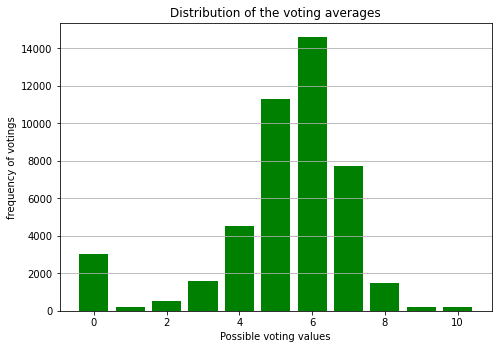

In [15]:
def count_values_in_col(df, number_inputted_col,sorted,*col_name):
    for i in range(number_inputted_col):
        return df[str(col_name[i])].value_counts(sort=sorted, ascending=sorted)

to_plot =count_values_in_col(rating1, 1, False, 'vote_average') 

# Let's make a plot:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rating_values=[]
for i in range(min(rating1['vote_average']), max(rating1['vote_average'])+1):
    rating_values.append(i)
plt.title('Distribution of the voting averages')
plt.xlabel('Possible voting values')
plt.ylabel('frequency of votings')

ax.grid(axis="y") # horizontal line grid outcome 
ax.bar(rating_values,to_plot, color='green')
plt.show()

### Observation and Interpretation
We decided to use in this case a bar chart because we wanted to see the distribution and the amount of each category. 
This bar chart shows voting values between 0 and 10. Users of platforms could grade movies between these values and they weren't deterred to vote 0 for their most hated or for the worst movies of all time. In generell, people gave rather an average vote of 5 or 6. Not many movies could determine 10 votes for themself. We have almost normal distribution excluding the 0-values. 

## 2.2 Let's have a look at the usage amount of genres 

In [16]:
def drop_empty_lists(df, number_col, *column_names):
    for i in range(number_col):
        df = df[df.astype(str)[str(column_names[i])] != '[]']
        df = df.reset_index() # to reset the indexes of the data after [] removing
    return df
# example usages for genres: drop_empty_lists(genres, 1, 'genres')

genres = pd.read_csv("movies_metadata.csv")

# remove rows in which no genre is defined:
genres = rem_nan_specified(genres,'genres')

genres = remove_duplicates(genres)

# Check if there are genres that not contain latin letters and remove them:
genres = check_latin_letters(genres, 1, 'genres')

genres = column_to_dict(genres, "genres")

genres = drop_empty_lists(genres, 1, 'genres')

/home/c/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


the shape of the input was:  (45466, 24)
the shape of the output is:  (45466, 24)
the shape of the input was:  (45453, 25)
the shape of the output is:  (45453, 25)


In [17]:
# Create lists which will be used to create new dataframes:
genreid_list=[]
name_list=[]
movieid_list=[]

for row in range(len(genres['genres'])):
    current_movieid = genres['id'][row]
    for element in genres['genres'][row]:
        genreid_list.append(element['id'])
        name_list.append(element['name'])
        movieid_list.append(current_movieid)        

In [18]:
# We create new pandas dataframe with which we will work:
df_only_genres =  pd.DataFrame(list(zip(movieid_list, genreid_list, name_list)), 
               columns =['movieId', 'id', 'name']) 

In [19]:
df_only_genres_without_movieinfo =  pd.DataFrame(list(zip(genreid_list, name_list)), columns =['id', 'name']) 

# We need df_only_genres_without_movieinfo only to see which different genres are used in general.
# Therefore, we can remove duplicates:
df_only_genres_without_movieinfo  = remove_duplicates(df_only_genres_without_movieinfo )
# we delete the old index values which are no longer needed anymore:
df_only_genres_without_movieinfo = df_only_genres_without_movieinfo.drop(['index'],axis=1)


length=len(df_only_genres_without_movieinfo['name'])
print(f"There are {length}.It follows that the genre IDs aren\'t comparable to the number of genres because they are much higher than {length}.") 
to_drop = df_only_genres_without_movieinfo.drop(df_only_genres_without_movieinfo.index[:19])
df_only_genres_without_movieinfo = df_only_genres_without_movieinfo.drop(df_only_genres_without_movieinfo.index[19:])

There are 32.It follows that the genre IDs aren't comparable to the number of genres because they are much higher than 32.


In [20]:
# Remove all genres which are only production companies:
for single_id in to_drop['id']:
    df_only_genres = df_only_genres[df_only_genres.id != single_id]
df_only_genres.reset_index() 

,index,movieId,id,name
0,0,862,16,Animation
1,1,862,35,Comedy
2,2,862,10751,Family
3,3,8844,12,Adventure
4,4,8844,14,Fantasy
...,...,...,...,...
90290,91069,439050,10751,Family
90291,91070,111109,18,Drama
90292,91071,67758,28,Action
90293,91072,67758,18,Drama


In [21]:
# Sort the rows by the genre name:
df_only_genres = df_only_genres.sort_values(['name'])

In [22]:
# count the frequency of genres:
counted_gen =  count_values_in_col(df_only_genres, 1,True, 'name')

# generate a list of the counted genre names:
cou = counted_gen.index.tolist()

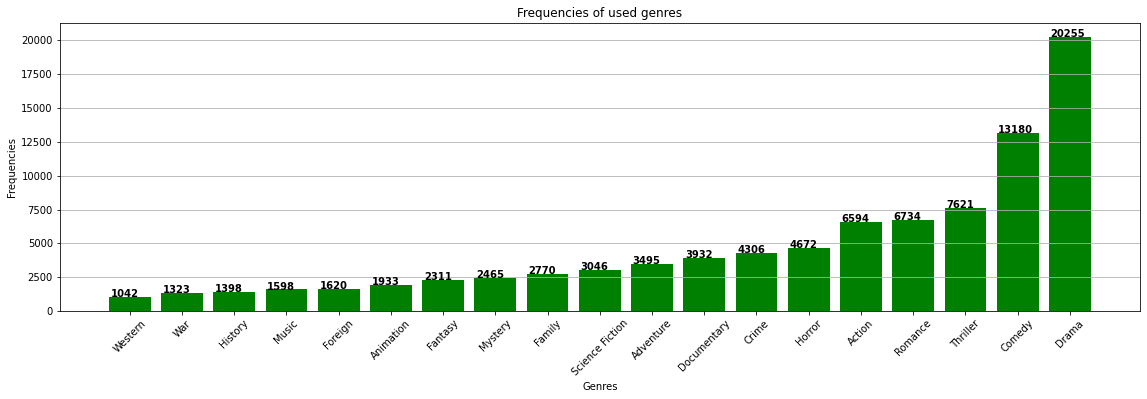

In [23]:
# Let's come to our final plotting:
fig = plt.figure(figsize=(15,4))
ax = fig.add_axes([0,0,1,1])

for i, v in enumerate(counted_gen):
    ax.text(i - 0.37, v +0 , str(v), color='black', fontweight='bold') # get the numbers on the bars
    
ax.grid(axis='y')

plt.title('Frequencies of used genres')
plt.xlabel('Genres')
plt.ylabel('Frequencies')

x_pos = range(len(cou))
plt.xticks(rotation=45)

ax.bar(cou,counted_gen, color='green')
plt.show()

### Observation and Interpretation

Here we used a grid with horizontal lines because there are so much genres that it would be hard to estimate the amount of the most right bars. <br>
Additionally, we decided to write the height of each bar on its top. The reason for that is that the differences among these bars can't be seen that easy by only looking at the y-axis. Furthermore, the range of genre amounts is too big for rescaling the y-axis. Therefore, the viewer gets the best insight into the data by first glance when we use the numbers on the bars.

The most used genres in movies are Drama and Comedy. Drama is with more than 20000 movies at the top of the ranking of all genres. Western, War and History are the genres with the lowest amount of films. The bar chart shows that the genres are not well distributed. This can be that Drama and Comedy are the most beloved movie genres in generell and producers makes more of such films to earn more profit or/and the users of the websites (TMDb: https://www.themoviedb.org/of; IMDb: https://www.imdb.com/), who seems to be western oriented, could prefer these genres more. 

## 2.3 Compare the countries in film production 

In [24]:
# We will need these functions in this chapter:
# We remove all movies/rows which are not released so far. The reason is that we want to compare 
# the amount of productions per continent until so far. Therefore:
def remove_status_not_released(df, number_columns, *columns):
    print("the shape of the input was: ", df.shape) 
    
    for i in range(number_columns):
        df = df[df[str(columns[i])] == 'Released'] # only keep the rows in which are True values in the specified column
    
    df = df.reset_index(drop= True)
    
    # Remove the column with the old indices which was added by the df.reset_index() function:
    try:
        df = df.drop(['index'],axis=1)
    except:
        pass
    
    print("the shape of the output is: ", df.shape) 
    
    return df

# Ignore the release_date month and day and only consider the years of the movies:
def str_time_to_year(dataframe, *columns):
    
    for col in columns:
        dataframe[col] = pd.to_datetime(dataframe[col], errors="coerce", yearfirst=True)
        dataframe[col] = [x if pd.isna(x) else x.year for x in dataframe[col]]
        
    return dataframe


In [25]:
# We always load the whole dataset again and clean it then up in the interesting columns. 
# That's because we want to get as much movies/samples as possible for each visualization.
# Otherwise, the we couldn't have a look at ca. 45.000 movies but only 657!

prod_countries = pd.read_csv("movies_metadata.csv")

prod_countries = rem_nan_specified(prod_countries,'production_countries', 'id', 'release_date')
prod_countries = remove_duplicates(prod_countries)
prod_countries = check_latin_letters(prod_countries, 1, 'production_countries', 'release_date')
prod_countries = column_to_dict(prod_countries,"production_countries")
prod_countries = drop_empty_lists(prod_countries,1,'production_countries')

# Now we need the release date to generate the wished visualization:
prod_countries = str_time_to_year(prod_countries, "release_date")

prod_countries = remove_status_not_released(prod_countries, 1, 'status') 
# 'status' describes if a film was already released

# Convert the prod_countries to numbers:
columns_to_numeric(prod_countries,'release_date')


/home/c/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


the shape of the input was:  (45466, 24)
the shape of the output is:  (45379, 24)
the shape of the input was:  (45366, 25)
the shape of the output is:  (45366, 25)
the shape of the input was:  (39157, 26)
the shape of the output is:  (38845, 25)


,level_0,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,...,1995,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,...,1995,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,...,1995,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,...,1995,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,...,1995,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38840,45361,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,30840,tt0102797,en,Robin Hood,...,1991,0.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Robin Hood,False,5.7,26.0
38841,45362,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,...,2011,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
38842,45363,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,...,2003,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
38843,45364,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,...,1917,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [26]:
print(f"""
We have the oldest movie from {min(prod_countries['release_date'])}
and the newest from {max(prod_countries['release_date'])}.
It follows that we have a range of 143 years.
Because it can be divided by 13 such that each time interval consists of exactly 13 years,
we choose 13 to divide the movies into bins.
""")


We have the oldest movie from 1874
and the newest from 2017.
It follows that we have a range of 143 years.
Because it can be divided by 13 such that each time interval consists of exactly 13 years,
we choose 13 to divide the movies into bins.



In [27]:
# This function is only used this time, therefore it is in the box where it is used:
# Aim of function: We want to replace the years by year intervals in the dataframe:
def change_years_into_intervals(df,col, 
                                wished_intervals=[min(prod_countries['release_date']),min(prod_countries['release_date'])+13+1,
                                                  min(prod_countries['release_date'])+13*2+1,min(prod_countries['release_date'])+13*3+1,
                                                  min(prod_countries['release_date'])+13*4+1,min(prod_countries['release_date'])+13*5+1,
                                                  min(prod_countries['release_date'])+13*6+1,min(prod_countries['release_date'])+13*7+1,
                                                  min(prod_countries['release_date'])+13*8+1,min(prod_countries['release_date'])+13*9+1,
                                                  min(prod_countries['release_date'])+13*10,max(prod_countries['release_date'])+1]
                     
                               ): # this function is for release dates
    df[col] = pd.cut(x=df[col], bins=wished_intervals,right=False)
    return df

prod_countries=change_years_into_intervals(prod_countries, 'release_date') # release date is already modified such that
# there are only years and not months or days in it.



In [28]:
# Clean up the ID values:
prod_countries = columns_to_numeric(prod_countries, 'id')

# not all values became numeric (containing '-'), therefore use remove nan function again:
prod_countries = rem_nan_specified(prod_countries, 'id') 


the shape of the input was:  (38845, 25)
the shape of the output is:  (38845, 25)


In [29]:
# Create lists which will become filled columns of a new helping dataframe:
countryid_list = []
countryname_list = []
movieid_list = []

for row in range(len(prod_countries['production_countries'])):
    current_countryid = prod_countries['id'][row]
    for element in prod_countries['production_countries'][row]:

        try:
            countryid_list.append(element['iso_3166_1'])
        except: 
            raise ValueError('Other type of dictionary key found.')
            
        countryname_list.append(element['name'])
        movieid_list.append(current_countryid)

# Create a dataframe which helps plotting:
df_only_prod_countries_without_movieinfo =  pd.DataFrame(list(zip(countryid_list, countryname_list,prod_countries['release_date'])), 
               columns =['countryId', 'name', 'year_interval']) 




In [30]:
# Count how often a production country appears in the dataset:
counted_countries = count_values_in_col(df_only_prod_countries_without_movieinfo,1,False,'name')
list_all_countries = counted_countries.index.tolist()


In [31]:
df_only_prod_countries =  pd.DataFrame(list(zip(movieid_list, countryid_list, countryname_list, prod_countries['release_date'])), 
               columns =['movieId', 'countryId', 'name', 'year_interval']) 


In [32]:
def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

# Example 
list_of_continents=[]
for i in df_only_prod_countries_without_movieinfo['name']:
    
    try:
        list_of_continents.append(country_to_continent(i))
        
    except:
        # Here are countries which are not recognized by the function.
        # Because they are not many we can hard code the related coninents here:
        
        if i == "Cote D'Ivoire" or i=="Libyan Arab Jamahiriya":
            list_of_continents.append('Africa')
            
        elif i == "Soviet Union" or i == "Serbia and Montenegro" or i=="Yugoslavia" or i=="East Germany" or i=="Czechoslovakia": 
            list_of_continents.append('Europe') 
            # For the Soviet Union we have chosen 'Europe' because the function sorts 'Russia'
            # also to 'Europe'. However, the Soviet Union was very large and lay also in Asia
            
        elif i == "United States Minor Outlying Islands":
            list_of_continents.append('North America') 
            
        elif i == "Netherlands Antilles":
            list_of_continents.append('South America') 
            
        elif i == "French Southern Territories" or i=="Antarctica":
            list_of_continents.append('Antarctica') 
            
        elif i == "Palestinian Territory":
            list_of_continents.append('Asia') 

len(list_of_continents) # the list is as long as the counted_countries with same order

# --> Add the list_of_continents to the dataframe:
df_only_prod_countries_without_movieinfo['continents'] = list_of_continents
df_only_prod_countries['continents']  = list_of_continents


In [33]:
# We no longer need the single country names of each movie/row. Therefore, remove them:
df_only_prod_countries_without_movieinfo = df_only_prod_countries_without_movieinfo.drop(['countryId', 'name'],axis=1)


For the visualization we also need the number of productions. Therefore, we have to count the number of movies for each continent (for each time interval):

In [34]:
def count_duplicates(df):
    df = (df.fillna(pd.Interval(0,199,closed='left'))\
          .groupby(df.columns.tolist()).apply(len)\
          .rename('frequencies')\
          .reset_index()\
          .replace('',np.nan)\
          .sort_values(by = ['frequencies'], ascending = False))
    return df

# Get for each time interval how many movies where produced in each continent:
df2 = count_duplicates(df_only_prod_countries_without_movieinfo)

# Sort the rows by time ('year_interval'):
df2 = df2.sort_values(by = 'year_interval') 


Now we have the number of productions with respect to country and time interval. Now we are ready to plot the visualization.

In [35]:
df_get_continents = df2.drop(['year_interval','frequencies'],axis=1)

df_get_continents = count_duplicates(df_get_continents)

# we only need the contient names here:
list_with_continents = df_get_continents['continents'].tolist()


In [36]:
# Convert the time intervals of type pd.Intervals to strings such that we can plot them at the x-axis:
df2 = column_type_bool(df2, {'year_interval':str})


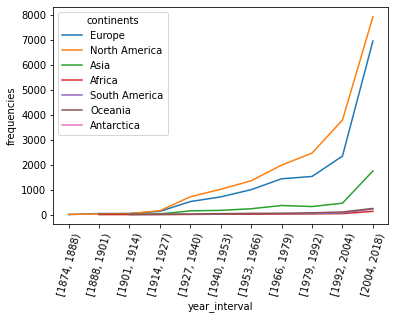

In [37]:
# Finally we plot:
ax = sns.lineplot(x='year_interval', y='frequencies', hue='continents',  sizes=(20,500), data=df2)
pic = plt.setp(ax.get_xticklabels(), rotation=75)



### Observation and Interpretation

For best visualization we chose the line chart because we can observe the change over the years. It gives you the opportunity to plot a lot of information although the user has an excellent overview. 

By plotting the continents and not the single countries we avoid an information overflow. The same applies to the years which are summarized in intervals.<br>
Furthermore, this time we decided to use a grid in the visualization. In this case it is handy because the user should not loose the overview. At each moment it shall be clear at which time interval we are and how much movies each continent produced at this time span.

We can observe that the film industry grew immensely over the past few decades. Especially, North America and Europe became very prominent since 1992. Nevertheless, you have to consider that the databases which the data came from , can be very biased. Maybe, there aren't all movies registered.


# 3. deeper look into the data

## 3.1 
as a first plot we want to analysize the ratings.csv by looking at the mean of all ratings from each user

In [39]:
rats_user_mean = rates.groupby("userId").rating.mean().round(2) # we take the means of the ratings grouped by users & 
# round them to 2 decimals, since this is sufficient for analyzing
rats_user_mean = rats_user_mean.reset_index()
rats_user_mean

,userId,rating
0,1,4.28
1,2,3.32
2,3,3.10
3,4,3.50
4,5,4.27
...,...,...
270891,270892,3.64
270892,270893,3.67
270893,270894,2.52
270894,270895,4.30


<AxesSubplot:title={'center':'average ratings of each user'}, xlabel='rating', ylabel='userId'>

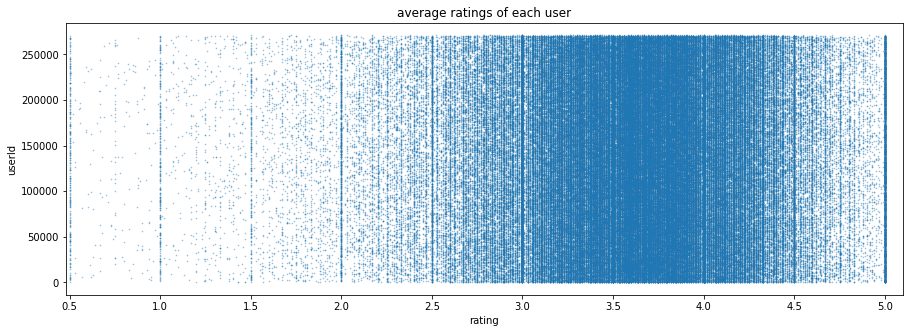

In [40]:
xti = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
rats_user_mean.plot.scatter("rating","userId", s=0.4, alpha=0.4, figsize=(15,5), title="average ratings of each user",xticks= xti, xlim =(0.48,5.1))

### Observation and Interpretation
Here we choose a scatter plot to get the distribution of a big amount of samples in one graph.
Unlike the voting before, this rating system has a range from 0 to 5.

A majority of the users rate their films at 3 to 4 stars. 
There is a tendency for the averages of users to whole & .5 number ratings
Most averages are rather good than bad. 


to get another perspective on this data we put the numbers into ranges to make a bar plot

In [41]:
rat_categ = rats_user_mean["rating"].to_frame() 
ranges = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
rat_categ = rat_categ.groupby(pd.cut(rat_categ.rating, ranges)).count()

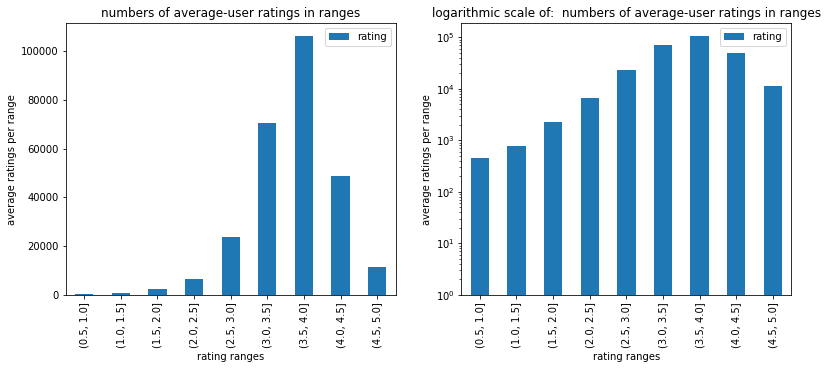

In [42]:
figure, axes = plt.subplots(1, 2)
rat_categ.plot.bar(ax=axes[0], figsize=(13,5), title="numbers of average-user ratings in ranges")
rat_categ.plot.bar(ax=axes[1], log=True, figsize=(13,5), title="logarithmic scale of:  numbers of average-user ratings in ranges")

axes[0].set_ylabel("average ratings per range")
axes[0].set_xlabel("rating ranges")
axes[1].set_ylabel("average ratings per range")
axes[1].set_xlabel("rating ranges")
print()

### Observation and Interpretation
The previous scatter plot shows all ratings but with the bar chart we can get distribution of a big amount of samples on one graph.

Here we see practically the same as in the plot before but the distribution is is now readable in numbers.
The non-logarithmic graph is the better choice here.
The left graph looks like a gaussian distribution with a peak from 3.5 - 4, which is a good sign that the data is correct.

In [43]:
del rats_user_mean
del rat_categ

## 3.2 Attributes & correlations between them


Scince we now only analyze numeric columns we can use more of the data from the 
movies_metadata.csv file than in the first preprocessing

In [44]:
met_years = pd.read_csv("movies_metadata.csv")
met_years = met_years[["id", "budget", "revenue", "vote_average", "popularity", "release_date"]]
met_years = remove_nan_rows(met_years) 
met_years = remove_duplicates(met_years)

inspect_df(met_years) # this makes looking into the data & looking for preprocessing- ToDo´s very easy

met_years = columns_to_numeric(met_years, "budget", "id")
met_years = str_time_to_tuple(met_years, "release_date")

met_years = remove_nan_rows(met_years)  # in case some function translated errors into nan´s, we remove them

c:\users\acer\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


..info from the remove_nan_rows() call..
the shape of the input was:  (45466, 6)
the shape of the output is:  (45376, 6)

 index             int64
id               object
budget           object
revenue         float64
vote_average    float64
popularity       object
release_date     object
dtype: object 
 ------------------------------------------- 
 ------------------------------------------- 
first element of column > index < :  0
first element type:  <class 'numpy.int64'> 


first element of column > id < :  862
first element type:  <class 'str'> 


first element of column > budget < :  30000000
first element type:  <class 'str'> 


first element of column > revenue < :  373554033.0
first element type:  <class 'numpy.float64'> 


first element of column > vote_average < :  7.7
first element type:  <class 'numpy.float64'> 


first element of column > popularity < :  21.946943
first element type:  <class 'float'> 


first element of column > release_date < :  1995-10-30
first element 

In [45]:
ranges = [1940, 1953, 1966, 1979, 1992, 2005, 2017]

met_years["release_date"] = [x[0] for x in met_years["release_date"]]
met_years["year_range"] = pd.cut(met_years.release_date, ranges)
met_years = remove_nan_rows(met_years)
met_years = met_years[met_years.revenue != 0] # unfortunately we have a lot of missing = 0 Values we need to filter out
met_years = met_years[met_years.budget != 0]
met_years

..info from the remove_nan_rows() call..
the shape of the input was:  (45363, 8)
the shape of the output is:  (43112, 8)


,index,id,budget,revenue,vote_average,popularity,release_date,year_range
0,0,862,30000000,373554033.0,7.7,21.9469,1995,"(1992, 2005]"
1,1,8844,65000000,262797249.0,6.9,17.0155,1995,"(1992, 2005]"
3,3,31357,16000000,81452156.0,6.1,3.85949,1995,"(1992, 2005]"
5,5,949,60000000,187436818.0,7.7,17.9249,1995,"(1992, 2005]"
8,8,9091,35000000,64350171.0,5.5,5.23158,1995,"(1992, 2005]"
...,...,...,...,...,...,...,...,...
42920,45163,24049,12000000,19000000.0,6.9,1.323587,2007,"(2005, 2017]"
43059,45311,280422,750000,3.0,6.0,0.201582,2014,"(2005, 2017]"
43069,45321,62757,800000,1328612.0,5.8,0.903061,2006,"(2005, 2017]"
43071,45323,63281,2000000,1268793.0,4.0,0.121844,2010,"(2005, 2017]"


unfortunately I wasnt able to plot a legend for the next graph
but we instead printet the year intervals with their coresponding colours 

In [46]:
col_dict = ["b", "r", "g", "m", "c", "y", "k"]
col_dict = dict(zip(met_years.groupby("year_range").mean().reset_index()["year_range"].to_numpy(), col_dict))#lazy solution
colours = [col_dict[x] for x in met_years["year_range"]]
col_dict
# blue, red, green, magenta, cyan, yellow, black, = col_dict  || bec.: unfortunately I wasnt able to plot a -LEGEND-

{Interval(1940, 1953, closed='right'): 'b',
 Interval(1953, 1966, closed='right'): 'r',
 Interval(1966, 1979, closed='right'): 'g',
 Interval(1979, 1992, closed='right'): 'm',
 Interval(1992, 2005, closed='right'): 'c',
 Interval(2005, 2017, closed='right'): 'y'}

<AxesSubplot:xlabel='budget', ylabel='revenue'>

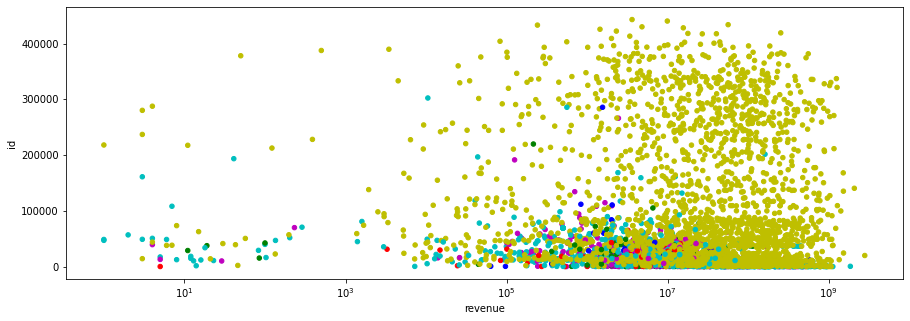

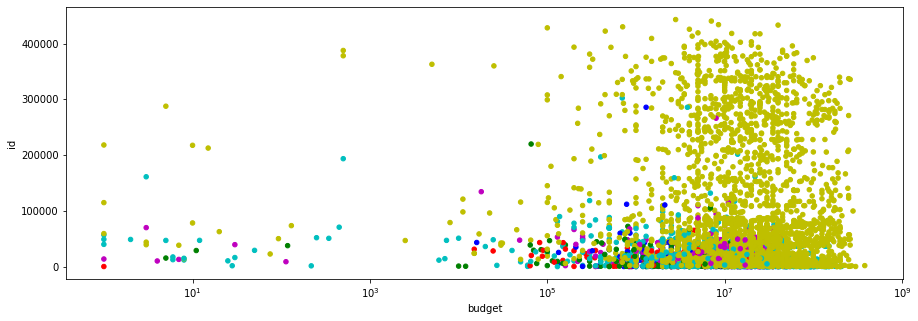

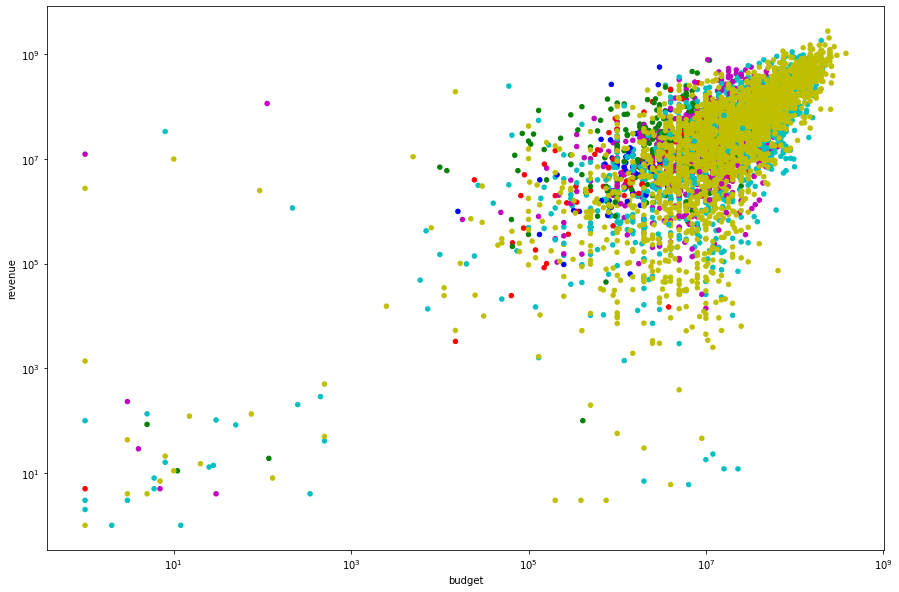

In [96]:
met_years.plot.scatter(x="revenue", y="id", legend=True, logx=True, c=colours, figsize=(15,5)) #alpha=0.6,
met_years.plot.scatter(x="budget", y="id", logx=True, c=colours, figsize=(15,5)) #alpha=0.6,
met_years.plot.scatter(x="budget", y="revenue", legend=True, logx=True, logy=True, c=colours, figsize=(15,10)) 

### Observation and Interpretation
 - 1st plot (revenue/ID) and 2nd plot (budget/ID):
     Films in the last twelve years (yellow points) are remarkable high in budget and also high in revenue. It seems like that for making a film nowadays it is the norm to invest more than $1.000.000.
 - 3rd plot: budget/revenue
     Most films are in the upperright side of the graph. They have in the norm a high budget and a high revenue. Just a few have a high budget and low revenue. These film must have been flops in the movie branche. To the contrary fewer films could reach a high revenue with a low budget. These film have cashed up immensely. 

let´s compare the attributes budget & revenue clearer:

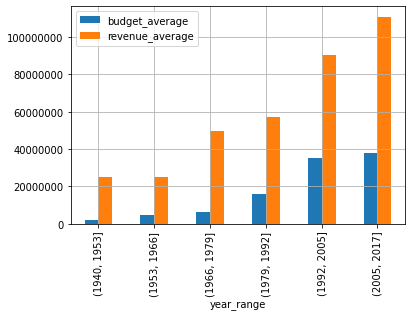

In [101]:
tes = met_years.groupby("year_range").mean()
tes = tes.drop(["id","index", "release_date", "vote_average"], axis=1).round(0)
tes = tes.rename(columns = {"budget":"budget_average", "revenue":"revenue_average"}) 
f = plt.figure()
plt.ticklabel_format(style = 'plain')
tes.plot(kind="bar", grid=True, ax=f.gca())
plt.show()

### Observation and Interpretation
With this visualization you can compare budget and revenue side by side over the years.

We clearly see that the average return of investment decreased over time & was it´s best in early years of the industry.
We also see that the money which went in & out the film-industrie drasticly increased over time.
The budget for 1992-2005 & 2005-2017 was similiar but the revenue increased after 2005 i.e. the ROI increased.

to see the ROI´s clearer we add them to the table & print it.

In [49]:
tes["ROI_rate"] = tes.apply(lambda row: row.revenue_average / row.budget_average, axis=1)
tes

,index,budget_average,revenue_average,ROI_rate
year_range,,,,
"(1940, 1953]",5781.0,1901655.0,25155675.0,13.228306
"(1953, 1966]",4908.0,4925371.0,24986272.0,5.072973
"(1966, 1979]",5661.0,6422825.0,49852138.0,7.761715
"(1979, 1992]",4699.0,15840347.0,57261709.0,3.614928
"(1992, 2005]",5694.0,35441364.0,90532740.0,2.554437
"(2005, 2017]",22003.0,37929046.0,110934863.0,2.924800


## 3.3 scatter matrix to discover possible correlations between all relevant numeric attributes

In [50]:
range_dict = dict({"b":"1940-1953", "r":"1953-1966" , "g":"1966-1979" , "m":"1979-1992" , "c":"1992-2005" , "y":"2005-2017"})
year_ranges = [range_dict[x] for x in colours]

In [51]:
source = met_years[["budget", "revenue", "vote_average", "popularity"]].copy()
source["year_ranges"] = year_ranges

alt.data_transformers.disable_max_rows()
# to exclude the dominant coloumn/s exchange source in the next line to source[source.year_ranges != "2005-2017"]
# or to source[source.year_ranges != "2005-2017"][source.year_ranges != "1992-2005"]
alt.Chart(source[source.year_ranges != "2005-2017"][source.year_ranges != "1992-2005"]).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='year_ranges'
).properties(
    width=150,
    height=150
).repeat(
    row=['popularity', 'vote_average', 'revenue'],
    column=['revenue', 'vote_average', 'popularity']
).interactive()

<ipython-input-51-8caf8a326cf9>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alt.Chart(source[source.year_ranges != "2005-2017"][source.year_ranges != "1992-2005"]).mark_circle().encode(


alt.RepeatChart(...)

### Observation and Interpretation
This Plot Matrix only shows Data between 1940 and 1992. Since in the following 25 years the film business increased immensly and that is also portrayed as a large number of movies in our dataset, the data would overlap the old one and therefore we wouldn't be able to analyze everything. Therefore, we decided to do the plot twice but with different time frames. 

-We can observe between this timeframe the years between 1979 and 1992 had the most profit since their revenues were the highest. Also we can observe that in this decade the amount of movies compared to earlier years were growing. Altough the movies of that time episode didn't strike in high popularity, most films still got a well average of votes between 6 and 8 of 10. However, there are only a few outliners which have a high rank in popularity: 3 movies of 1966 - 1979 and 1 film of 1953 - 1966 have in generell a higher ranking and only one movie, made between 1979 and 1992, has the most points by far. 

In [52]:
# the most films occured during 1992-2017, which is why we temp. turned them of for the plot
met_years.groupby("year_range").id.count() 

year_range
(1940, 1953]      70
(1953, 1966]     131
(1966, 1979]     234
(1979, 1992]     730
(1992, 2005]    1672
(2005, 2017]    2480
Name: id, dtype: int64

In [95]:
source = met_years[["budget", "revenue", "vote_average", "popularity"]].copy()
source["year_ranges"] = year_ranges

alt.data_transformers.disable_max_rows()

alt.Chart(source).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='year_ranges'
).properties(
    width=150,
    height=150
).repeat(
    row=['popularity', 'vote_average', 'revenue'],
    column=['revenue', 'vote_average', 'popularity']
).interactive()

alt.RepeatChart(...)

### Observation and Interpretation
The plot popularity and vote_average shows, that only movies with a higher vote than 6 can be popular.
Revenue is mostly lower than $1.5 billion and hardly any other movie are over that Dollar mark. 
There is some correlation between revenue and the average of votes. Films with higher revenue have in generell a higher average of votes. 
The last plot shows no correlation between revenue and popularity. 


# 4. Interactive working with clusters

## 4.1 Change the dataframe into a numerical numpy array


In [53]:
start_df = pd.read_csv("movies_metadata.csv")


c:\users\acer\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [54]:
# Remove all columns which doesn't help to cluster or what you cannot convert into numerical information:
start_df = start_df.drop(['overview','poster_path','homepage','imdb_id','original_title','title','tagline'], axis=1)
start_df = remove_duplicates(start_df)

# we no longer need the single movie id: 
start_df = start_df.drop(['id','index'],axis=1) # remove index column which shows the old indices replaced by
# the new ones in the function 'remove_duplicates'

### 4.1.1 Work with 'adult' column

In [55]:
# Start with column 'adult': bool shall become numeric and nan values shall become -1

start_df.adult.fillna('-1', inplace=True)
start_df['adult'] = start_df['adult'].replace(['True'],'1')
start_df['adult'] = start_df['adult'].replace(['False'],'0')

# There are some values which doesn't fit to the column, e.g. author name, replace them:
start_df['adult'] = start_df['adult'].replace(to_replace=r'[^-1,0,1]', value=-1, regex=True)

### 4.1.2 'belongs_to_collection' column

In [56]:
# Next convert 'belongs_to_collection' to numerical True/False/Unknown:
# We need to get the ID out of the dictionaries:
start_df.belongs_to_collection.fillna('{}', inplace=True)
start_df = column_to_dict(start_df, 'belongs_to_collection')

# We only need the id of the collection in the column or -1 for NaN not a dictionary:
ind = 0
for ele in start_df['belongs_to_collection']:
    
    if ele != {}:
        try:
            start_df['belongs_to_collection'][ind] = ele['id']
        except:
            start_df['belongs_to_collection'][ind] = -1
    ind += 1
    
start_df['belongs_to_collection'] = start_df['belongs_to_collection'].replace([{}],'-1')



<ipython-input-56-a753d7162216>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_df['belongs_to_collection'][ind] = ele['id']
<ipython-input-56-a753d7162216>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_df['belongs_to_collection'][ind] = -1


### 4.1.3 'budget' column

In [57]:
start_df = columns_to_numeric(start_df, 'budget')
start_df.budget.fillna('0', inplace=True) # we use 0 here and not -1 because the dataset gives films of unkonwn
# budget a value of 0.


### 4.1.4 'genres' column

In [58]:
start_df.genres.fillna('[]', inplace=True)

In [59]:
def mklist(n): # creates a list of lists
    for _ in range(n):
        yield []

# We want to create a nested list in which each list represents one genre. These lists are later used as new
# columns filled with 1-s and 0-s depending whether a specific movie has that genre (1) or not (0).:
new_col_genre_list = list(mklist(len(cou)))


In [60]:
# Here we append the lists for every movie/sample:
for liste in start_df['genres']:
    
    liste = eval(liste) # convert string into list of dictionaries!
    
    if len(liste)==0:
        for ind_l, ele_l in enumerate(cou):
                
                new_col_genre_list[ind_l].append(0)

    my_used_ind_list = []
    for index_ele,ele in enumerate(liste):    

        if not isinstance(ele, dict):
            pass

        elif ele['name'] in cou: # cou is a list with all possible genre names defined in earlier part of this work

            my_ind = cou.index(ele['name'])
            new_col_genre_list[my_ind].append(1)
            my_used_ind_list.append(my_ind)

        if index_ele == len(liste)-1: # the last element of a row in column 'genres'
            
            for ind_l, ele_l in enumerate(cou):
                if ind_l not in my_used_ind_list:
                    new_col_genre_list[ind_l].append(0)
    
print('Done')

Done


In [61]:
start_df = start_df.drop(['genres'], axis=1)

In [62]:
for ind, ele in enumerate(new_col_genre_list):
    
    start_df[f'genre{ind}'] = ele # append dataframe by the first date information    

### 4.1.5 'original_language' column

In [63]:
# count the frequency of genres:
counted_languages =  count_values_in_col(start_df, 1, True, 'original_language')

# Get rid of all numeric info in that column:
start_df['original_language'] = start_df['original_language'].replace(to_replace=r'[^a-zA-Z]', value=-1, regex=True)

# generate a list of the counted genre names:
lang_list = counted_languages.index.tolist() # here are all possible languages

In [64]:
# give each language its own value by simply using the index:
for index, element in enumerate(lang_list):
    start_df.loc[start_df.original_language == element, 'original_language'] = index    

### 4.1.6 'popularity' column 

In [65]:
start_df = columns_to_numeric(start_df, 'popularity')
start_df.budget.fillna('-1', inplace=True)

# Look that there are only numbers in the column:
not_allowed = r'[^a-zA-Z\'"{}\[\]\(\)/\\\\+\#%&=?!_;:-]'
start_df['popularity'] = start_df['popularity'].replace(to_replace=not_allowed, value=-1, regex=True)

### 4.1.7 'production_companies' column

Same procedure as in 'genres':

Problem: We have to much companies: 26.202 that would be the same amount of new columns in the new modified dataframe. Therefore, we always use only the first company of a movie and store its index from the comp_list in which are all companies listed.

In [66]:
start_df.production_companies.fillna('[]', inplace=True)

In [67]:
comp_list = []

for liste in start_df['production_companies']:
    
    liste = eval(str(liste)) # convert string into list of dictionaries!
   
    if not isinstance(liste, list):
        liste = []
        
    for ele in liste: 
        try:
            comp_list.append(ele['id'])
            
        except:
            pass

# Remove duplicates from comp_list:
comp_list = list( dict.fromkeys(comp_list) )

# Now we have all possible companies (each once) in one list!

In [68]:
for row_ind,liste in enumerate(start_df['production_companies']):
    
    liste = eval(liste) # convert string into list of dictionaries!

    if not isinstance(liste, list):
        liste = []
        
    if len(liste)==0:
        start_df['production_companies'][row_ind]=-1
     

    elif not isinstance(liste[0], dict):
        start_df['production_companies'][row_ind]=-1

    elif liste[0]['id'] in comp_list: 
        
        start_df['production_companies'][row_ind]=comp_list.index(liste[0]['id'])

    else:
        start_df['production_companies'][row_ind]=-1

print('Done')

<ipython-input-68-c7721d5a65d3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_df['production_companies'][row_ind]=comp_list.index(liste[0]['id'])
<ipython-input-68-c7721d5a65d3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_df['production_companies'][row_ind]=-1


Done


### 4.1.8 'production countries' column

Again similar process: Use only the first production country because there are in total too much of them.

In [69]:
start_df.production_countries.fillna('[]', inplace=True)

In [70]:
# We already have the list of all possible countries: list_all_countries

for row_ind,liste in enumerate(start_df['production_countries']):

    liste = eval(liste)  # convert string into list of dictionaries!
    
    if not isinstance(liste, list):
        liste = []
        
    if len(liste) == 0:
        start_df['production_countries'][row_ind] = -1

    elif not isinstance(liste[0], dict):
        start_df['production_countries'][row_ind] = -1

    elif liste[0]['name'] in list_all_countries:
        start_df['production_countries'][row_ind] = list_all_countries.index(liste[0]['name'])
        # use the index of a country in the country list to get a numerical encoding for the country name
        
    else:
        start_df['production_countries'][row_ind] = -1
  
print('Done')

<ipython-input-70-826887cfb8b6>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_df['production_countries'][row_ind] = list_all_countries.index(liste[0]['name'])
<ipython-input-70-826887cfb8b6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_df['production_countries'][row_ind] = -1
<ipython-input-70-826887cfb8b6>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_df['production_countries'][row_ind] = -1


Done


### 4.1.9 ' release_date' column

Split one column into three columns to get all numbers as info:

In [71]:
start_df.production_countries.fillna('0-0-0', inplace=True) 
# We use 0 here and not -1 because the -1 is the splitting part 

# Check if all are only letters:
start_df['release_date'] = start_df['release_date'].replace(to_replace=r'[^0-9-]', value=-1, regex=True)

# Make three columns out of one:

# Split the year-month-day into three parts (year, month, day): 
only_dates = start_df['release_date'].str.split('-', 3, expand=True)

start_df = start_df.drop(['release_date'], axis=1)

start_df['date1'] = only_dates[0].tolist() # append dataframe by the first date information
start_df['date2'] = only_dates[1].tolist()
start_df['date3'] = only_dates[2].tolist()
# The release day, month, year columns as result

### 4.1.10 'status' column

In [72]:
start_df.status.fillna('-1', inplace=True)

list_status = [] # shall become list with all possible statuses
for i in start_df['status']:
    if i not in list_status:
        list_status.append(i)

for index,ele in enumerate(list_status):
    # Replace all entries which have the ele as value with the index of ele in 'list_status'. 
    # 'list_status' contains every possible status. Aim is it to have a column only filled with numbers.
    start_df['status'] = start_df['status'].replace([ele], index)

# Every entry which has something else than a index of 'list_status' gets value -1 because it is not valid:
start_df['status'] = start_df['status'].replace(to_replace=r'[^0-5]', value=-1, regex=True)

### 4.1.11 'runtime' column

In [73]:
start_df = columns_to_numeric(start_df, 'runtime')

### 4.1.12 'revenue' column

In [74]:
start_df = columns_to_numeric(start_df, 'revenue')

### 4.1.13 'vote_average' column

In [75]:
start_df = columns_to_numeric(start_df, 'vote_average')

### 4.1.14 'vote_count' column

In [76]:
start_df = columns_to_numeric(start_df, 'vote_count')

### 4.1.15 'video' column

In [77]:
start_df = columns_to_numeric(start_df, 'video')
start_df.adult.fillna('-1.0', inplace=True)

### 4.1.16 'spoken_languages' column 

In [78]:
start_df.spoken_languages.fillna('[]', inplace=True)

In [79]:
# Create a list in which are all languages:
list_more_lang = []

for liste in start_df['spoken_languages']:
    
    liste = eval(str(liste)) # convert string into list of dictionaries!
    
    if not isinstance(liste, list):
        liste = []
        
    for e in liste:
        if e['name'] not in list_more_lang:
            list_more_lang.append(e['name'])            

In [80]:
# Creating a nested list. Each list in it will later become a column in the dataframe and stand for one 
# concrete language:
new_col_lang_list = list(mklist(len(list_more_lang)))

In [81]:
for liste in start_df['spoken_languages']:

    liste = eval(liste)  # convert string into list of dictionaries!
    
    if not isinstance(liste, list):
        liste = []
        
    if len(liste) == 0:
        
         for ind_l, ele_l in enumerate(new_col_lang_list):
                new_col_lang_list[ind_l].append(0)
                

    my_used_ind_list = []
    visited_ids = []
    
    for index_ele, ele in enumerate(liste):

        if not isinstance(ele, dict):
            pass

        elif ele['name'] in list_more_lang and ele['name'] not in visited_ids:
            
            visited_ids.append(ele['name'])
            
            my_ind = list_more_lang.index(ele['name'])
            new_col_lang_list[my_ind].append(1) 
            my_used_ind_list.append(my_ind)
        
        if index_ele == len(liste)-1: # we have the last element of a row
            
            for ind_l, ele_l in enumerate(list_more_lang):
                if ind_l not in my_used_ind_list:
                    new_col_lang_list[ind_l].append(0)
        
print('Done')

Done


In [82]:
# Each lanuage will become its own column. Therefore, we don't need the original column 'spoken_languages'
# anymore:
start_df = start_df.drop(['spoken_languages'], axis=1)

In [83]:
for ind, ele in enumerate(new_col_lang_list):

    start_df[f'language{ind}'] = ele 
    # append the dataframe by adding new columns    

## 4.2 Dimensionality reduction by t-SNE 

In [84]:
final_df = start_df
final_df = final_df.fillna(0)
final_df = final_df.astype(int)

In [85]:
df_array = np.asarray(final_df)

In [86]:
X_embedded = TSNE(n_components=2).fit_transform(df_array) # use numpyarray

## 4.3 Using k-means to cluster the X_embedded t-SNE 

In [87]:
tsne_df = pd.DataFrame(X_embedded, columns=['tsne1', 'tsne2'])

In [88]:
sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(tsne_df)
    sse.append([k, km.inertia_])    

c:\users\acer\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


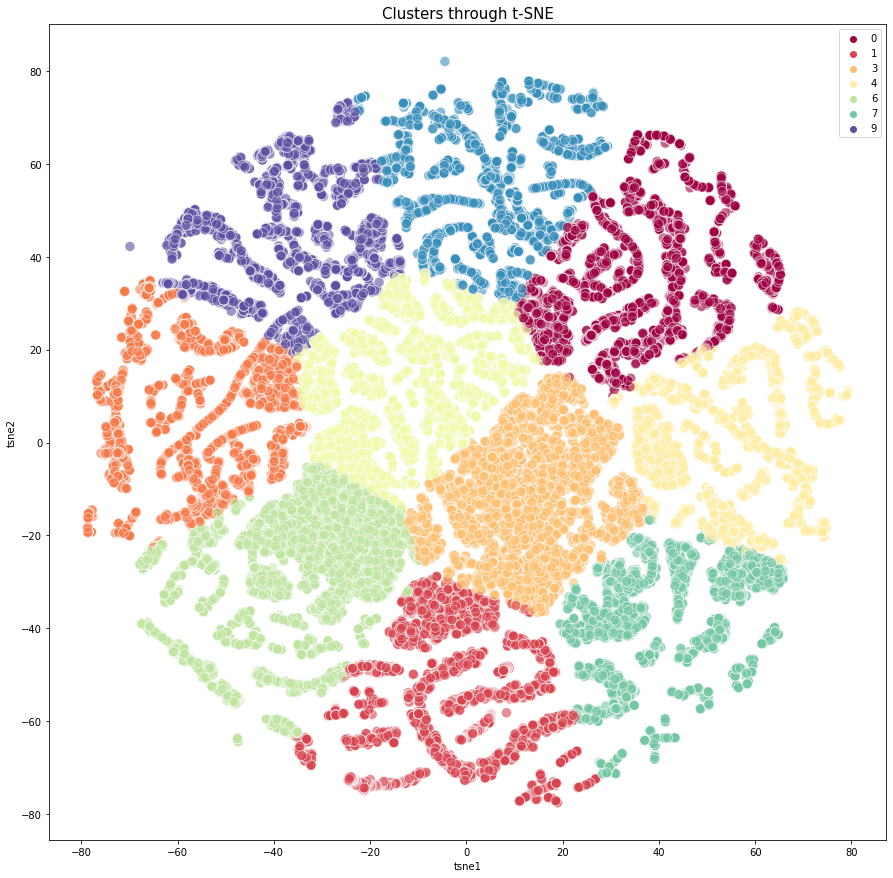

In [89]:
@interact(number_of_labels=(0,20)) 
def plot_clusters(number_of_labels):
    global kmeans_tsne_scale
    
    kmeans_tsne_scale = KMeans(n_clusters=number_of_labels, n_init=10, max_iter=20, init='k-means++', random_state=42).fit(tsne_df)
    labels_tsne_scale = kmeans_tsne_scale.labels_
    clusters_tsne_scale = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_scale})], axis=1)
    plt.figure(figsize = (15,15))
    sns.scatterplot(clusters_tsne_scale.iloc[:,0],clusters_tsne_scale.iloc[:,1],hue=labels_tsne_scale, palette=sns.color_palette("Spectral", as_cmap=True)
, s=100, alpha=0.6).set_title('Clusters through t-SNE', fontsize=15)
    
    plt.legend()
    plt.show()      

### Observation and Interpretation
This cluster plot has some similaries with a brain and like a brain every part is somehow connected with another, however, there are some small clusters at the edge of the "brain" which can have some deep connections and belong together. Let's look if there is a bigger connection in one cluster. 

## 4.4 finally we have a deeper look into a selected cluster

In [90]:
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]
def get_samples_from_clust(clustNum):
    #return tsne_df.T[ClusterIndicesNumpy(clustNum, kmeans_tsne_scale.labels_)].T # get the correspondent t.sne values
    return final_df.T[ClusterIndicesNumpy(0, kmeans_tsne_scale.labels_)].T # # get the correspondent dataset values

In [91]:
clustadata = get_samples_from_clust(0)

In [92]:
clustadata

,adult,belongs_to_collection,budget,original_language,popularity,production_companies,production_countries,revenue,runtime,status,...,language65,language66,language67,language68,language69,language70,language71,language72,language73,language74
3,0,-1,16000000,91,3,6,93,81452156,127,0,...,0,0,0,0,0,0,0,0,0,0
10,0,-1,62000000,91,6,23,93,107879496,106,0,...,0,0,0,0,0,0,0,0,0,0
15,0,-1,52000000,91,10,18,124,116112375,178,0,...,0,0,0,0,0,0,0,0,0,0
20,0,91698,30250000,91,12,42,93,115101622,105,0,...,0,0,0,0,0,0,0,0,0,0
39,0,-1,0,91,0,97,121,676525,106,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45385,0,-1,1254040,78,0,11856,141,0,90,0,...,0,0,0,0,0,0,0,0,0,0
45386,0,-1,750000,85,0,23669,77,3,0,0,...,0,0,0,0,0,0,0,0,0,0
45396,0,-1,800000,91,0,-1,-1,1328612,100,0,...,0,0,0,0,0,0,0,0,0,0
45399,0,-1,2000000,91,0,17646,77,1268793,107,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
cols = ["belongs_to_collection", "budget", "original_language", "popularity", "production_companies", "production_countries", "revenue", "runtime"]
source = clustadata[cols]

alt.data_transformers.disable_max_rows()

alt.Chart(source).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative')
).properties(
    width=150,
    height=150
).repeat(
    row=cols,
    column=cols[::-1]
).interactive()

alt.RepeatChart(...)

### Observations

We did't find any outstanding correlations. The cluster seems to be very homogenious. However, we observe a weak positive correlation betwenn revenue and budget. 
That we can't observe further correlations could be because there are lot of missing values (notated as 0 or -1) in the data. So the information of the movies is often patchy, therefore, it is very difficult for us to observe some pattern. 

# 5. Conclusion

We took this Movie dataset because it has a vast amount of samples (45000) and since we are fascinated by movies, we wanted to collect experience by working with a large amount of movie data.

We think that the data as a whole was pretty homogenious and although we didn't find any outstanding artifacts, we found some interesting patterns. Like for example, the return-of-investment-rate had a strict decrease over time but an increase in recent years.

